In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost

## лаб. работа

In [2]:
data_df = pd.read_csv('data.csv', sep=';')
data_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SaleCategory
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,1
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,1
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,1


#### 2. Первоначальный анализ данных

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
data_df.dtypes.value_counts()
# датасет содержит 81 переменную (с id)
# из них 37 числовых
# 43 категориальных - больше половины (без учета числовых категориальных)

object     43
int64      35
float64     3
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019D85B7F5F8>,
      dtype=object)

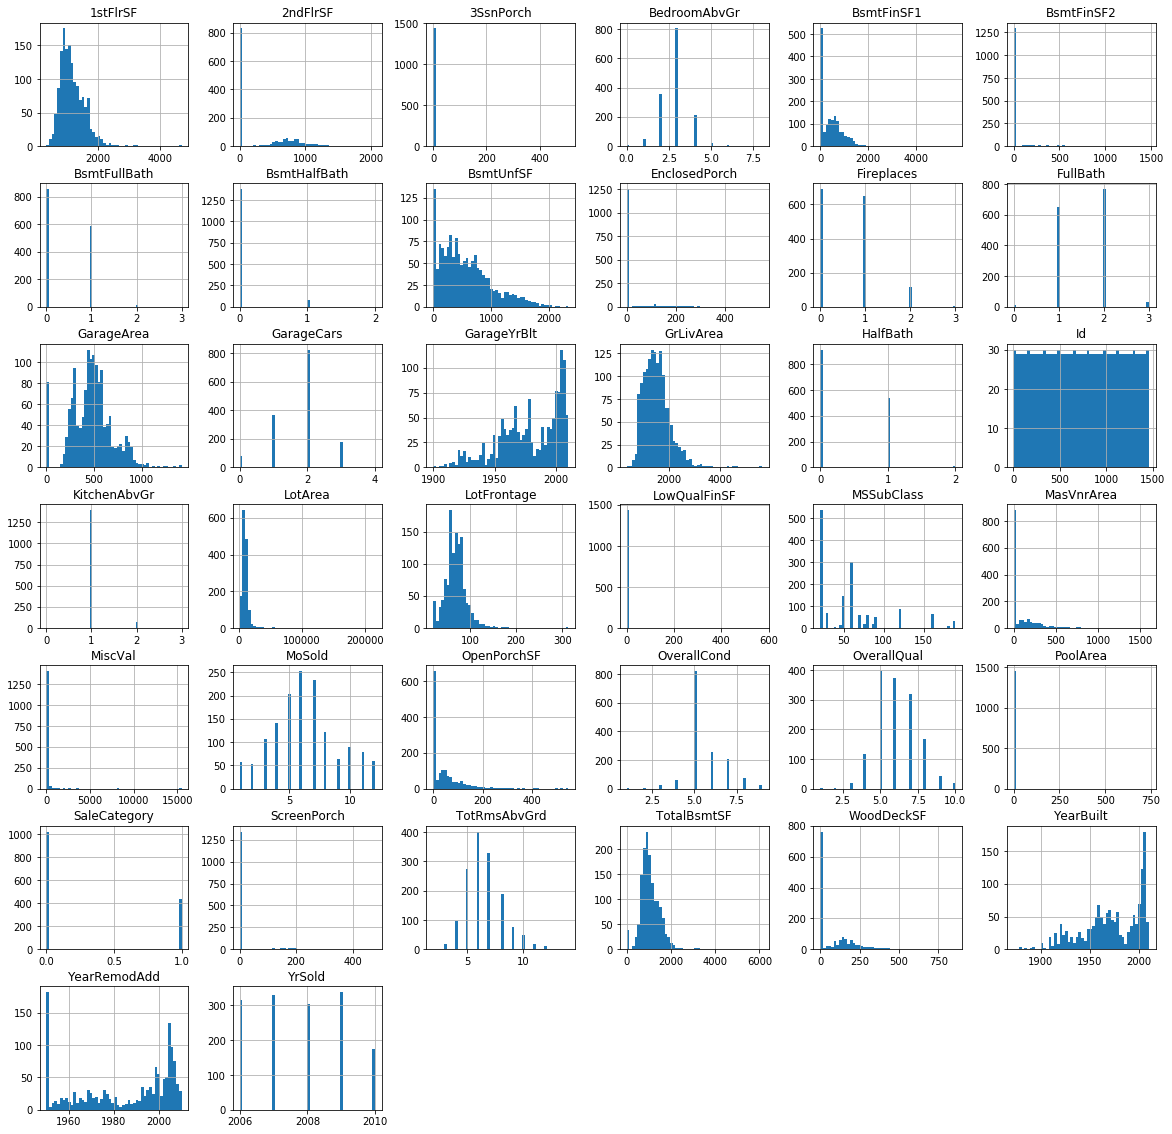

In [5]:
# распределения
data_df.hist(bins=50, figsize=(20,20))

большинство домов построены в начале 2000-х.
есть выброс в 1950 по ремонту домов.
большинство домов имеют 5-7 комнат.
большинство домов имеют жилую площать 1000 м2 и являютя одноэтажными.

есть бинарное значение (SaleCategory) - цель и дискретные (по сути тоже категориальные:
1. TotRmsAbvGrd, 
2. MoSold, 
3. YrSold, 
4. YearRemodAdd,
5. YearBuild,
6. OverallQual,
7. OverallCond,
8. MSSubClass,
9. KitchenAbvGr,
10. HalfBath,
11. GarageYrBlt,
12. GarageCars,
13. FullBath,
14. Fireplaces,
15. BedroomAbvGr,
16. Bedroom,
17. Kitchen

In [6]:
import seaborn as sns

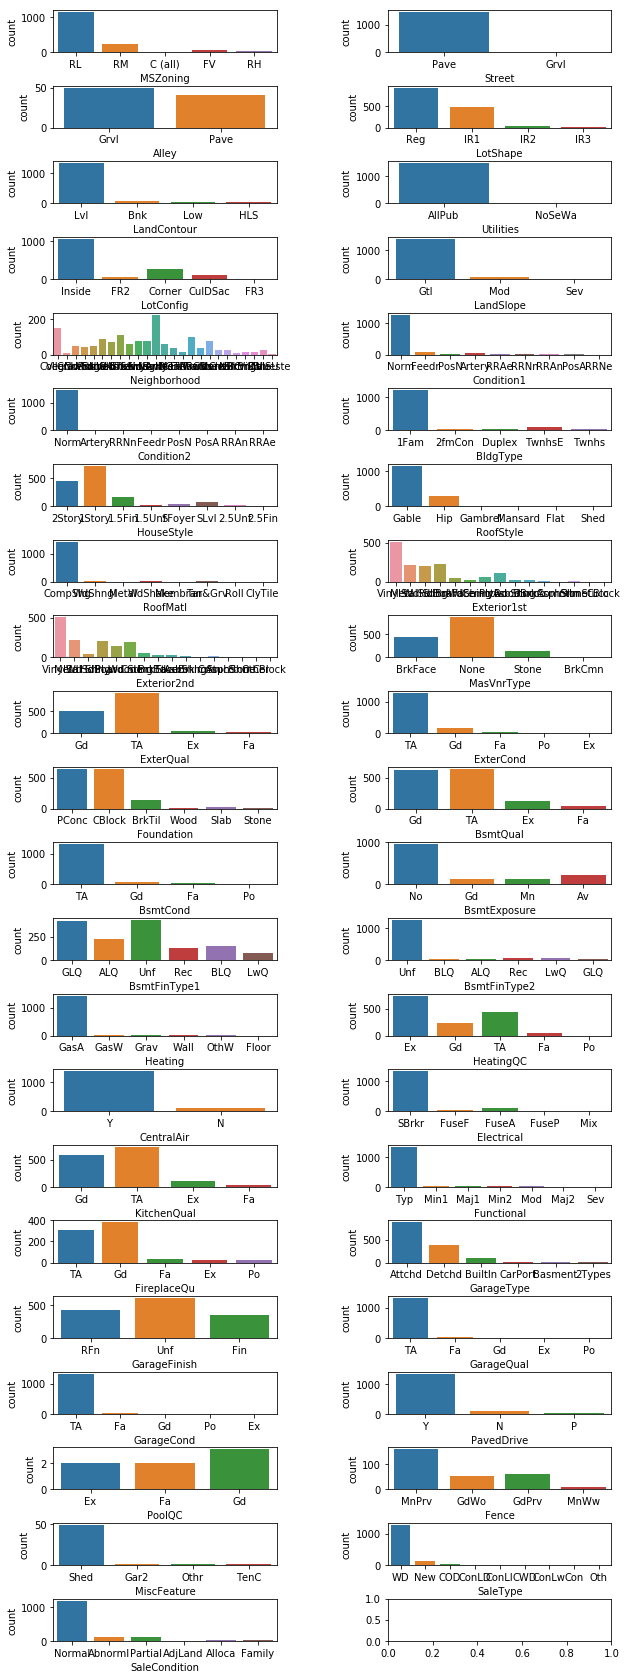

In [7]:
# посмотрим на статистики для категориальных значений 
objects = data_df.dtypes[data_df.dtypes == 'object'].index

fig, axs = plt.subplots(22, 2, figsize = (10,30))

for i in axs:
    for i,j in zip(objects, axs.flat):
        g = sns.countplot(x=i, data=data_df, ax=j)
        
fig.subplots_adjust(hspace=.8, wspace=.5)

Для признаков Street, Utilities, Condition2 характерен только 1 признак для практически всех наблюдений
Эти признаки можно не включать в модель

#### 3. стратегия работы с пропущенными данными

In [8]:
def missingdata(raw_df):
    '''
    считаем кол-во и долю пропущеных значений
    '''
    total = raw_df.isnull().sum().sort_values(ascending = False)
    percent = (raw_df.isnull().sum()/raw_df.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    return ms

In [9]:
missingdata(data_df)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


Выделить группы с по объему пропуска
1. 80 % и выше
2. 10-50%
3. меньше 10%

1 группа - статистичесми медодами восстановления не воспользоваться. Понять важность этих переменных экспертно и как она влияет на цель. 
Например PoolQC нет данных, так как у большинсва досов нет бассейнов (PoolArea = 0). Можно исключить данный признак из модели, а площадь бассейна приобразовать в бинарную переменную.
MiscFeature - другие х-ки (теннисные корты, лифт), большинство домов не имеет данных характеристик, тот же путь либо не используем в модели, либо делаем бинарным
Для Alley и Fence, можно применить onehotcoding

2 группа - понять важность переменной экспертно и как она влияет на цель. 
FireplaceQu - качество каминов. Половина домов не оборудована каминами, так что этот признак можно не использовать в модели. Оставить только наличие камина
LotFrontage - можно создать модель для предсказания потерянного значения

3 группа - применить статистические медоды: по моде, по среднему, по медиане

In [10]:
data_df.groupby(['SaleCategory']).mean()['LotFrontage']

SaleCategory
0    65.341232
1    81.182073
Name: LotFrontage, dtype: float64

#### 4. Работа с категориальными переменными

1. Предварительный анализ содержания категорий
1.1 Проанализировать связанные группы категорий: гаражи, камины, крыльцо, подвал
1.2 Проанализировать распределение в категориях по целевому значению


In [11]:
garage = data_df[['Id','GarageYrBlt','YearBuilt','GarageCars',
                  'GarageArea','GarageType','GarageFinish','GarageQual','GarageCond']]
garage.head()

,Id,GarageYrBlt,YearBuilt,GarageCars,GarageArea,GarageType,GarageFinish,GarageQual,GarageCond
0,1,2003.0,2003,2,548,Attchd,RFn,TA,TA
1,2,1976.0,1976,2,460,Attchd,RFn,TA,TA
2,3,2001.0,2001,2,608,Attchd,RFn,TA,TA
3,4,1998.0,1915,3,642,Detchd,Unf,TA,TA
4,5,2000.0,2000,3,836,Attchd,RFn,TA,TA


In [12]:
garage.corr()

,Id,GarageYrBlt,YearBuilt,GarageCars,GarageArea
Id,1.000000,0.000072,-0.012713,0.016570,0.017634
GarageYrBlt,0.000072,1.000000,0.825667,0.588920,0.564567
YearBuilt,-0.012713,0.825667,1.000000,0.537850,0.478954
GarageCars,0.016570,0.588920,0.537850,1.000000,0.882475
GarageArea,0.017634,0.564567,0.478954,0.882475,1.000000


GarageYrBuilt коррелирована с YearBuilt и для модели не несет информации
Аналогично GarageCars и GarageArea

In [13]:
garage.groupby(['GarageQual']).count()['GarageArea']

GarageQual
Ex       3
Fa      48
Gd      14
Po       3
TA    1311
Name: GarageArea, dtype: int64

In [14]:
garage.groupby(['GarageCond']).count()['GarageArea']

GarageCond
Ex       2
Fa      35
Gd       9
Po       7
TA    1326
Name: GarageArea, dtype: int64

In [15]:
data_df.groupby(['SaleCategory', 'GarageFinish']).count()['GarageArea']

SaleCategory  GarageFinish
0             Fin             157
              RFn             242
              Unf             547
1             Fin             195
              RFn             180
              Unf              58
Name: GarageArea, dtype: int64

распеределение у этих двух признаков однинаковое
можно оставить один, например GarageQual, присвоив баллы по 5-ти балльной шкале
для GarageFinish можно использовать onehotcoding

Для переменных со значениями качества применить шкалу баллов (HeatingQC, KitchenQual, Fence, ExterQual, ExterCond, BsmtQual, BsmtCond)
CentralAir - бинарное
К остальным onehotcoding

In [16]:
data_df.groupby(['ExterQual']).count()['Id']

ExterQual
Ex     52
Fa     14
Gd    488
TA    906
Name: Id, dtype: int64

In [17]:
data_df.groupby(['ExterCond']).count()['Id']

ExterCond
Ex       3
Fa      28
Gd     146
Po       1
TA    1282
Name: Id, dtype: int64

In [18]:
data_df.groupby(['BsmtQual']).count()['Id']

BsmtQual
Ex    121
Fa     35
Gd    618
TA    649
Name: Id, dtype: int64

In [19]:
data_df.groupby(['BsmtCond']).count()['Id']

BsmtCond
Fa      45
Gd      65
Po       2
TA    1311
Name: Id, dtype: int64

In [20]:
data_df.groupby(['SaleCategory','CentralAir']).count()['Id']

SaleCategory  CentralAir
0             N              91
              Y             934
1             N               4
              Y             431
Name: Id, dtype: int64

In [21]:
data_df.groupby(['Utilities']).count()['Id']

Utilities
AllPub    1459
NoSeWa       1
Name: Id, dtype: int64

#### 5. Углубленный анализ данных

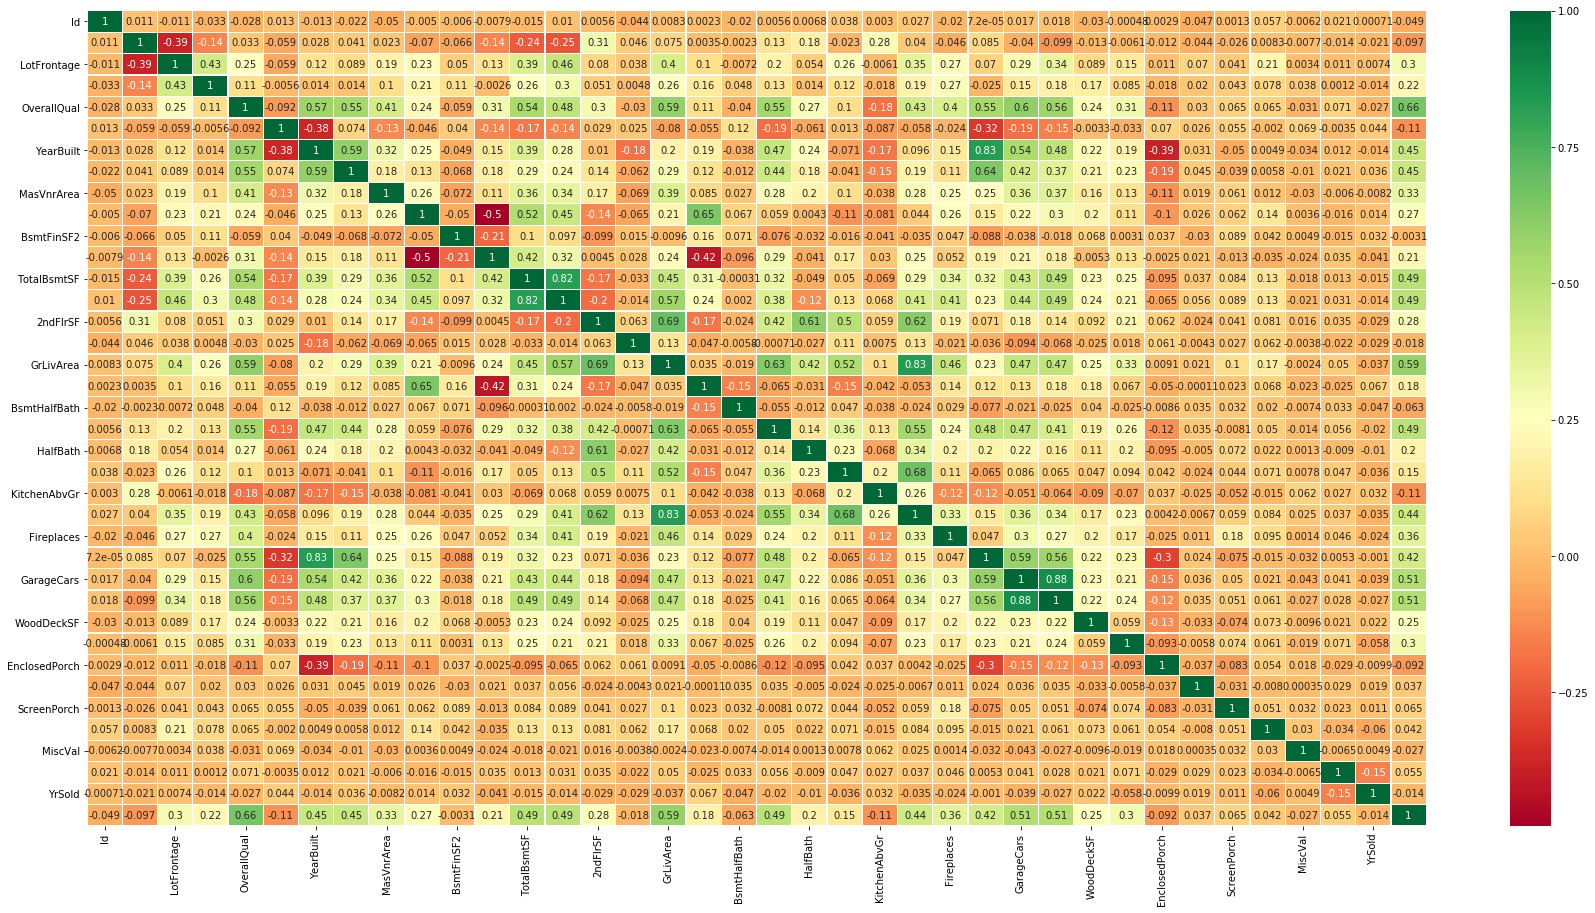

In [22]:
sns.heatmap(data_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(30,15)
plt.show()

существенной отрицательной корр. нет
есть положительная корреляция между переменными

In [23]:
corr_matrix = data_df.corr()
corr_matrix['TotalBsmtSF'].sort_values(ascending=False)
# аналогично однонаправленые вектора так как площади 1-го этажа, подвала связаны физически, 
# можно оставить только значение жилой площади дома и переменную наличие подвала

TotalBsmtSF      1.000000
1stFlrSF         0.819530
OverallQual      0.537808
BsmtFinSF1       0.522396
SaleCategory     0.492566
GarageArea       0.486665
GrLivArea        0.454868
GarageCars       0.434585
BsmtUnfSF        0.415360
LotFrontage      0.392075
YearBuilt        0.391452
MasVnrArea       0.363936
Fireplaces       0.339519
FullBath         0.323722
GarageYrBlt      0.322445
BsmtFullBath     0.307351
YearRemodAdd     0.291066
TotRmsAbvGrd     0.285573
LotArea          0.260833
OpenPorchSF      0.247264
WoodDeckSF       0.232019
PoolArea         0.126053
BsmtFinSF2       0.104810
ScreenPorch      0.084489
BedroomAbvGr     0.050450
3SsnPorch        0.037384
MoSold           0.013196
BsmtHalfBath    -0.000315
YrSold          -0.014969
Id              -0.015415
MiscVal         -0.018479
LowQualFinSF    -0.033245
HalfBath        -0.048804
KitchenAbvGr    -0.068901
EnclosedPorch   -0.095478
OverallCond     -0.171098
2ndFlrSF        -0.174512
MSSubClass      -0.238518
Name: TotalB

In [24]:
data_df.describe()['GrLivArea']

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

In [25]:
corr_matrix = data_df.corr()
corr_matrix['GrLivArea'].sort_values(ascending=False)
# действительно чем больше комнат тем как правило больше площатдь
# эти величины однонаправлены и несут одинаковую информацию, для модели можно оставить только площадь

GrLivArea        1.000000
TotRmsAbvGrd     0.825489
2ndFlrSF         0.687501
FullBath         0.630012
OverallQual      0.593007
SaleCategory     0.586293
1stFlrSF         0.566024
BedroomAbvGr     0.521270
GarageArea       0.468997
GarageCars       0.467247
Fireplaces       0.461679
TotalBsmtSF      0.454868
HalfBath         0.415772
LotFrontage      0.402797
MasVnrArea       0.390857
OpenPorchSF      0.330224
YearRemodAdd     0.287389
LotArea          0.263116
WoodDeckSF       0.247433
BsmtUnfSF        0.240257
GarageYrBlt      0.231197
BsmtFinSF1       0.208171
YearBuilt        0.199010
PoolArea         0.170205
LowQualFinSF     0.134683
ScreenPorch      0.101510
KitchenAbvGr     0.100063
MSSubClass       0.074853
MoSold           0.050240
BsmtFullBath     0.034836
3SsnPorch        0.020643
EnclosedPorch    0.009113
Id               0.008273
MiscVal         -0.002416
BsmtFinSF2      -0.009640
BsmtHalfBath    -0.018918
YrSold          -0.036526
OverallCond     -0.079686
Name: GrLivA

In [26]:
data_df.describe()['TotRmsAbvGrd']

count    1460.000000
mean        6.517808
std         1.625393
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64

In [27]:
# корреляция по целевой переменной
corr_matrix = data_df.corr()
corr_matrix['SaleCategory'].sort_values(ascending=False)
#

SaleCategory     1.000000
OverallQual      0.658386
GrLivArea        0.586293
GarageArea       0.512544
GarageCars       0.511790
TotalBsmtSF      0.492566
FullBath         0.490005
1stFlrSF         0.488095
YearRemodAdd     0.447166
YearBuilt        0.446685
TotRmsAbvGrd     0.438496
GarageYrBlt      0.419525
Fireplaces       0.360984
MasVnrArea       0.334187
OpenPorchSF      0.304405
LotFrontage      0.298255
2ndFlrSF         0.275514
BsmtFinSF1       0.266621
WoodDeckSF       0.254786
LotArea          0.223034
BsmtUnfSF        0.214966
HalfBath         0.197952
BsmtFullBath     0.184700
BedroomAbvGr     0.145259
ScreenPorch      0.064980
MoSold           0.055392
PoolArea         0.041906
3SsnPorch        0.037141
BsmtFinSF2      -0.003101
YrSold          -0.014498
LowQualFinSF    -0.018005
MiscVal         -0.026928
Id              -0.049051
BsmtHalfBath    -0.062919
EnclosedPorch   -0.091844
MSSubClass      -0.096873
KitchenAbvGr    -0.110555
OverallCond     -0.110761
Name: SaleCa

In [28]:
data_df.groupby(['SaleCategory', 'OverallQual']).count()['Id']

SaleCategory  OverallQual
0             1                2
              2                3
              3               20
              4              115
              5              389
              6              323
              7              155
              8               16
              10               2
1             4                1
              5                8
              6               51
              7              164
              8              152
              9               43
              10              16
Name: Id, dtype: int64

Показатель OverallQual хорошо отделяет целевую переменную

In [29]:
# удалим ранее выбранные значения
drop_columns = ['TotalBsmtSF', 'GarageYrBlt','TotRmsAbvGrd','GarageCars', 
                'FireplaceQu', 'GarageCond', 'PoolQC', 'MiscFeature',
               'Street', 'Condition2', 'Utilities']
data_df.drop(drop_columns, axis = 1, inplace = True)


In [30]:
# заполним отсут. данные по статистикам
data_df['Electrical'].fillna(data_df['Electrical'].mode()[0], inplace = True)
data_df['MasVnrType'].fillna(data_df['MasVnrType'].mode()[0], inplace = True)
data_df['MasVnrArea'].fillna(data_df['MasVnrArea'].median(), inplace = True)
data_df['BsmtCond'].fillna(data_df['BsmtCond'].mode()[0], inplace = True)
data_df['BsmtFinType1'].fillna(data_df['BsmtFinType1'].mode()[0], inplace = True)
data_df['BsmtFinType2'].fillna(data_df['BsmtFinType2'].mode()[0], inplace = True)
data_df['GarageQual'].fillna(data_df['GarageQual'].mode()[0], inplace = True)
data_df['GarageFinish'].fillna(data_df['GarageFinish'].mode()[0], inplace = True)
data_df['GarageType'].fillna(data_df['GarageType'].mode()[0], inplace = True)

In [31]:
def scales(data):
    '''
    заполняем значения баллами
    '''
    if data == 'Fx':
        return 5
    elif data == 'Gd': 
        return 4
    elif data == 'TA':
        return 3
    elif data == 'Fa':
        return 2
    elif data == 'Po':
        return 1
    else:
        return 0

In [32]:
data_df['ExterQual_n'] = data_df['ExterQual'].apply(scales)
data_df['ExterCond_n'] = data_df['ExterCond'].apply(scales)
data_df['BsmtQual_n'] = data_df['BsmtQual'].apply(scales)
data_df['BsmtCond_n'] = data_df['BsmtCond'].apply(scales)
data_df['HeatingQC_n'] = data_df['HeatingQC'].apply(scales)
data_df['KitchenQual_n'] = data_df['KitchenQual'].apply(scales)
data_df['GarageQual_n'] = data_df['GarageQual'].apply(scales)
data_df['GarageFinish_n'] = data_df['GarageFinish'].apply(scales)
data_df['GarageType_n'] = data_df['GarageType'].apply(scales)

In [33]:
def bool_scales(data):
    '''
    заполняем значения CentralAir
    '''
    if data == 'Y':
        return 1
    else:
        return 0

In [34]:
data_df['CentralAir_n'] = data_df['CentralAir'].apply(bool_scales)

In [35]:
drop_columns1 = ['ExterQual', 'ExterCond','BsmtQual','BsmtCond', 
                'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageFinish',
               'GarageType', 'CentralAir']
data_df.drop(drop_columns1, axis = 1, inplace = True)


In [36]:
corr_matrix = data_df.corr()
corr_matrix['OverallQual'].sort_values(ascending=False)

OverallQual       1.000000
SaleCategory      0.658386
GrLivArea         0.593007
YearBuilt         0.572323
GarageArea        0.562022
YearRemodAdd      0.550684
FullBath          0.550600
1stFlrSF          0.476224
MasVnrArea        0.407252
Fireplaces        0.396765
OpenPorchSF       0.308819
BsmtUnfSF         0.308159
2ndFlrSF          0.295493
HalfBath          0.273458
CentralAir_n      0.272038
LotFrontage       0.251646
BsmtFinSF1        0.239666
WoodDeckSF        0.238923
BsmtCond_n        0.173367
BsmtFullBath      0.111098
LotArea           0.105806
BedroomAbvGr      0.101676
GarageQual_n      0.094703
ExterQual_n       0.077214
MoSold            0.070815
PoolArea          0.065166
ScreenPorch       0.064886
MSSubClass        0.032628
3SsnPorch         0.030371
ExterCond_n      -0.011630
YrSold           -0.027347
Id               -0.028365
LowQualFinSF     -0.030429
MiscVal          -0.031406
BsmtHalfBath     -0.040150
BsmtFinSF2       -0.059119
BsmtQual_n       -0.081955
K

In [37]:
data_df.dtypes.value_counts()

int64      42
object     26
float64     2
dtype: int64

In [38]:

object_columns = data_df.columns[data_df.dtypes == 'object']
    
data_df = pd.get_dummies(data_df, columns = object_columns, prefix=object_columns)


In [39]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 225 entries, Id to SaleCondition_Partial
dtypes: float64(2), int64(42), uint8(181)
memory usage: 760.0 KB


In [40]:
missingdata(data_df)

,Total,Percent
LotFrontage,259,17.739726


In [41]:
data_df.drop('LotFrontage', axis = 1, inplace = True)

In [42]:
missingdata(data_df)

,Total,Percent


#### 6. train/test 

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
train_70, test_30 = train_test_split(data_df, test_size=0.3, shuffle=True)

In [45]:
train_70.index = train_70['Id']
train_70 = train_70.drop('Id', axis=1)

In [46]:
test_30.index = test_30['Id']
test_30 = test_30.drop('Id', axis=1)

#### 7. Модели

готвим данные для обучения и тестирования модели

In [47]:
X_test = test_30.drop(['SaleCategory'], axis=1)
y_test = test_30['SaleCategory']

In [48]:
X_train = train_70.drop(['SaleCategory'], axis=1)
y_train = train_70['SaleCategory']

Используем для обучения модель RandomForestClassifier

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [50]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))

In [51]:
cols

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'ExterQual_n',
 'ExterCond_n',
 'BsmtQual_n',
 'BsmtCond_n',
 'HeatingQC_n',
 'KitchenQual_n',
 'GarageQual_n',
 'GarageFinish_n',
 'GarageType_n',
 'CentralAir_n',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl

In [52]:
# обучаем модель
clf = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=0)\
.fit(X_train[cols], y_train)

In [53]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 4)
print("Train: ", roc_auc_train)

Train:  0.9997


In [54]:
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]

roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 4)
print("Test: ", roc_auc_test)

Test:  0.981


обучаем модель LogisticRegression

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
clf_R = LogisticRegression(solver = 'liblinear', multi_class='ovr').fit(X_train[cols], y_train)

In [57]:
y_train_predict_LR = clf_R.predict_proba(X_train[cols])[:, 1]

roc_auc_train_LR = np.round(roc_auc_score(y_train, y_train_predict_LR), 4)
print("Train: ", roc_auc_train_LR)

Train:  0.9943


In [58]:
y_test_predict_LR = clf_R.predict_proba(X_test[cols])[:, 1]

roc_auc_test_LR = np.round(roc_auc_score(y_test, y_test_predict_LR), 4)
print("Test: ", roc_auc_test_LR)

# !LogisticRegression

Test:  0.982


In [63]:
# матрица ошибок с ошибками 1-го и 2-го рода
from sklearn.metrics import confusion_matrix
confusion_matrix_LR = confusion_matrix(y_test, y_test_predict_LR.round())
print(confusion_matrix_LR)

[[289  12]
 [ 18 119]]


289 + 119 правильно
! LogisticRegression

In [64]:

confusion_matrix_F = confusion_matrix(y_test, y_test_predict.round())
print(confusion_matrix_F)

[[292   9]
 [ 23 114]]


292 + 114 правильно

In [65]:
from sklearn.metrics import classification_report

In [66]:
print(classification_report(y_test, y_test_predict_LR.round()))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       301
           1       0.91      0.87      0.89       137

   micro avg       0.93      0.93      0.93       438
   macro avg       0.92      0.91      0.92       438
weighted avg       0.93      0.93      0.93       438



In [67]:
print(classification_report(y_test, y_test_predict.round()))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       301
           1       0.93      0.83      0.88       137

   micro avg       0.93      0.93      0.93       438
   macro avg       0.93      0.90      0.91       438
weighted avg       0.93      0.93      0.93       438



Лучшие переменные

Как и ожидалось наиболее информативная переменная OverallQual наиболее информативная
№2 - это жилая площадь дома

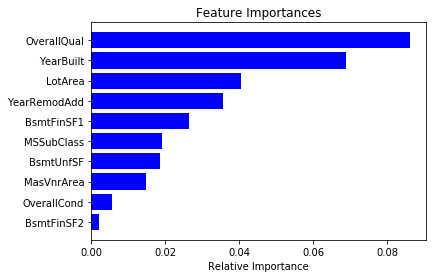

In [68]:
features = X_train.columns
importances = clf.feature_importances_[0:10]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [69]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

model = LogisticRegression(solver = 'liblinear', multi_class='ovr')
sfs_forward = SFS(model, 
           k_features=63, 
           forward=True, 
           floating=True, 
           verbose=1,
           scoring='roc_auc',
           cv=skf,
           n_jobs=-1)

sfs_forward = sfs_forward.fit(X_train.values, y_train.values,custom_feature_names=X_train.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   38.0s finished
Features: 1/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 221 out of 221 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
Features: 2/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished
Features: 3/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: 

Features: 21/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 194 out of 201 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 201 out of 201 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.4s finished
Features: 22/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.5s finished
Features: 23/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: D

Features: 37/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 178 out of 185 | elapsed:    3.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  37 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    0.8s finished
Features: 38/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    0.6s finished
Features: 39/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Para

[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.0s finished
Features: 49/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 166 out of 173 | elapsed:    7.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  49 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.4s finished
Features: 49/63[Parallel(n_jobs=-1)]: Us

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.3s finished
Features: 61/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 161 out of 161 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:    1.3s finished
Features: 62/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:    1.3s finished
Features: 63/63

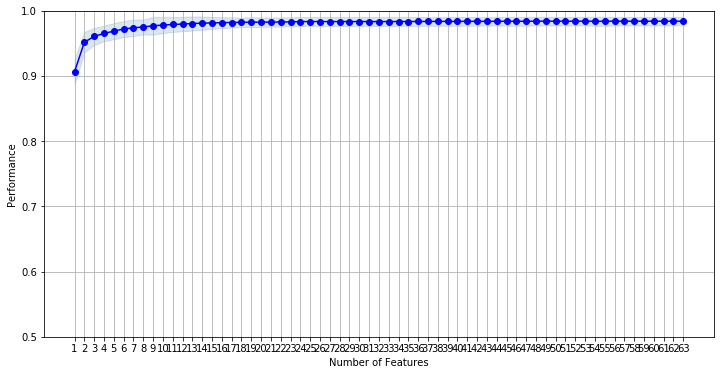

In [70]:
fig1 = plot_sfs(sfs_forward.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
plt.grid()
fig1.set_size_inches(12, 6)
plt.show()

In [71]:
sfs_forward.get_metric_dict()

{1: {'feature_idx': (2,),
  'cv_scores': array([0.91086556, 0.90357274, 0.87789309, 0.93254442]),
  'avg_score': 0.9062189537603903,
  'feature_names': ('OverallQual',),
  'ci_bound': 0.03128872631747867,
  'std_dev': 0.01951908344398175,
  'std_err': 0.01126934808071763},
 2: {'feature_idx': (2, 13),
  'cv_scores': array([0.93952118, 0.95797422, 0.93418695, 0.97420487]),
  'avg_score': 0.9514718032950078,
  'feature_names': ('OverallQual', 'GrLivArea'),
  'ci_bound': 0.025353687559151884,
  'std_dev': 0.01581658320183122,
  'std_err': 0.009131708569237368},
 3: {'feature_idx': (2, 7, 13),
  'cv_scores': array([0.95933702, 0.96464088, 0.94094371, 0.97715395]),
  'avg_score': 0.9605188890548007,
  'feature_names': ('OverallQual', 'BsmtFinSF1', 'GrLivArea'),
  'ci_bound': 0.020874188307126996,
  'std_dev': 0.013022103209250511,
  'std_err': 0.007518314793275873},
 4: {'feature_idx': (2, 7, 13, 81),
  'cv_scores': array([0.96478821, 0.973407  , 0.9456473 , 0.97618337]),
  'avg_score': 0.9

In [72]:

model_RF = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=0)
sfs_forward_RF = SFS(model_RF, 
           k_features=63, 
           forward=True, 
           floating=True, 
           verbose=1,
           scoring='roc_auc',
           cv=skf,
           n_jobs=-1)

sfs_forward_RF = sfs_forward_RF.fit(X_train.values, y_train.values,custom_feature_names=X_train.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 222 out of 222 | elapsed:   16.0s finished
Features: 1/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 221 out of 221 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
Features: 2/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   14.9s finished
[Parallel(n_

[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    1.4s finished
Features: 18/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:   17.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.3s finished
Features: 19/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 203 out of 203 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.5s finished
Features: 20/63[Parallel(n_jobs=-1)]: Using backend LokyBackend

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 186 out of 186 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.2s finished
Features: 37/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 185 out of 185 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    3.2s finished
Features: 38/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 out of 184 | elapsed:   16.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elap

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    5.0s finished
Features: 55/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 167 out of 167 | elapsed:   15.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    5.0s finished
Features: 56/63[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 166 out of 166 | elapsed:   15.4s finished
[

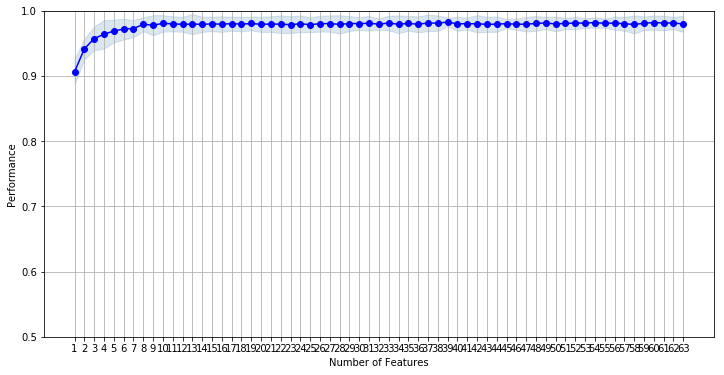

In [75]:
fig2 = plot_sfs(sfs_forward_RF.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
plt.grid()
fig2.set_size_inches(12, 6)
plt.show()

In [76]:
sfs_forward_RF.get_metric_dict()

{1: {'feature_idx': (2,),
  'cv_scores': array([0.91034991, 0.90342541, 0.87830372, 0.93254442]),
  'avg_score': 0.906155865810562,
  'feature_names': ('OverallQual',),
  'ci_bound': 0.03101202838242456,
  'std_dev': 0.01934646887257679,
  'std_err': 0.011169689011450925},
 2: {'feature_idx': (2, 13),
  'cv_scores': array([0.93576427, 0.95558011, 0.91798567, 0.95602509]),
  'avg_score': 0.9413387835349162,
  'feature_names': ('OverallQual', 'GrLivArea'),
  'ci_bound': 0.025281233625172917,
  'std_dev': 0.015771383714679513,
  'std_err': 0.009105612633163096},
 3: {'feature_idx': (2, 11, 13),
  'cv_scores': array([0.95812155, 0.97042357, 0.92746752, 0.9730103 ]),
  'avg_score': 0.9572557363993829,
  'feature_names': ('OverallQual', '2ndFlrSF', 'GrLivArea'),
  'ci_bound': 0.029005609247349694,
  'std_dev': 0.018094789206113335,
  'std_err': 0.010447031419079069},
 4: {'feature_idx': (2, 7, 11, 13),
  'cv_scores': array([0.96777164, 0.98022099, 0.92705689, 0.9800657 ]),
  'avg_score': 0.9